# Medical NER

In [1]:
PROJECT_NAME = "clinical-ner-maccrobat"

# Dataset to fine tune on
MACCROBAT = "ktgiahieu/maccrobat2018_2020"

# Dataset split amounts
TRAIN_SPLIT = 360
VAL_SPLIT = 40
TEST_SPLIT = 0

# External evaluation datasets (uses older datasets version and bigbio format)
NCBI = "bigbio/ncbi_disease"
BC5 = "bigbio/bc5cdr"

# Working directory setting
OUTPUT_DIR = "/kaggle/working/ner_runs"

# Models
model_config = {
    # General
    "DISTILBERT" : {
        "model_name" : "distilbert/distilbert-base-uncased"
    },
    "MODERNBERT" : {
        "model_name" : "answerdotai/ModernBERT-base"
    },
    # Domain specific
    "BIOMEDBERT" : {
        "model_name" : "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"
    },
    "BIOFORMER" : {
        "model_name" : "bioformers/bioformer-16L"
    },
    "BIOBERT" : {
        "model_name" : "dmis-lab/biobert-v1.1"
    }
}

## Imports

In [2]:
# Install hugging face libraries
!pip install transformers datasets evaluate seqeval scikit-multilearn wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 38.3 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
cudf-polars-cu12 25.6.0 requires pylibcudf-cu12==25.6.*, but you have pylib

In [3]:
# Base
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from datetime import datetime
from collections import defaultdict, Counter

# Hugging Face
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification, 
    Trainer, 
    TrainingArguments, 
    DataCollatorForTokenClassification, 
    EarlyStoppingCallback
)
import evaluate

# Iterative stratification
from skmultilearn.model_selection import iterative_train_test_split

# Softmax
from scipy.special import softmax

# Confusion matrix
from sklearn.metrics import confusion_matrix

# Garbage collection
import torch, gc
def reset_gpu():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    print("GPU memory reset.")

2025-11-16 19:12:17.103268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763320337.255883      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763320337.302876      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [4]:
# W&B Login (Kaggle Secrets)
from kaggle_secrets import UserSecretsClient
import wandb

WANDB_KEY = UserSecretsClient().get_secret("WANDB_API_KEY")
wandb.login(key=WANDB_KEY)

print("W&B logged in.")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kshitij-nevrekar (kshitij-nevrekar-nmims) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W&B logged in.


## Load Dataset

In [5]:
# Loading dataset
dataset = load_dataset(MACCROBAT)
print("Dataset loaded")
display(dataset)
print(f"\nDataset shape: {dataset.shape}")

README.md: 0.00B [00:00, ?B/s]

data.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

Dataset loaded


DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 400
    })
})


Dataset shape: {'train': (400, 2)}


In [6]:
# Load sample
sample = dataset['train'][100]
token_tag_pairs = list(zip(sample['tokens'], sample['tags']))
for token, tag in token_tag_pairs[:10]:
  print(f"{token}\t\t\t{tag}")

A			O
22			B-Age
-			I-Age
year			I-Age
-			I-Age
old			I-Age
Tibetan			B-Personal_background
man			B-Sex
without			B-History
significant			I-History


## Dataset Preprocessing

### Remove Unicode Spaces

In [7]:
# Regex for "normal" tokens:
# - words / digits: [A-Za-z0-9]+
# - punctuation: matches any char in string.punctuation
# - combined word-with-hyphen: like 'COVID-19'
valid_pattern = re.compile(r"^[\w]+$|^[^\w\s]$|^[\w]+[-][\w]+$")

weird_tokens = Counter()

for split in ["train"]:
    for tokens in dataset[split]["tokens"]:
        for tok in tokens:
            # Strip whitespace for detection but preserve original
            stripped = tok.strip()

            if stripped == "":
                weird_tokens[tok] += 1
                continue

            # If token does not match valid regex → weird
            if not valid_pattern.match(stripped):
                weird_tokens[tok] += 1

# Show top weird tokens
print("Found weird tokens:", len(weird_tokens))
for tok, count in weird_tokens.most_common(30):
    print(repr(tok), "→", count)

Found weird tokens: 1035
'\n' → 8682
'\u200a' → 846
'\u2005' → 392
'\u2009' → 222
"'s" → 164
'Fig.1' → 130
'’s' → 116
'Fig.2' → 108
'Fig.3' → 98
'Fig.1A' → 44
'Fig.4' → 42
'\u200b1' → 40
'mL.' → 38
'L.' → 38
'Fig.1B' → 32
'dL.' → 32
'Fig.2A' → 30
'2.5' → 30
'0.5' → 30
'\u200b2' → 26
'Fig.2B' → 24
'Fig.1a' → 22
'Fig.5' → 20
'):' → 20
'p.' → 18
'\u200b3' → 18
'1.5' → 18
'Inc.' → 18
'1.0' → 16
'2.8' → 16


In [8]:
UNICODE_WHITESPACE = [
    "\u200a", "\u2005", "\u2009", "\u200b",
    "\u00A0", "\u202F", "\u2060"
]

def clean_and_normalize_tokens(tokens, tags):
    new_tokens = []
    new_tags = []

    for tok, tag in zip(tokens, tags):

        # Remove unicode whitespace tokens completely
        for ws in UNICODE_WHITESPACE:
            tok = tok.replace(ws, "")

        # Treat newline explicitly
        if tok == "\n":
            new_tokens.append("[NEWLINE]")
            new_tags.append(tag)        # It's always "O" but we keep consistency
            continue

        # Remove empty / whitespace-only tokens
        if tok.strip() == "":
            continue

        # Keep everything else (digits, Fig. tokens, words, punctuation)
        new_tokens.append(tok)
        new_tags.append(tag)

    return new_tokens, new_tags

In [9]:
cleaned_rows = []

for ex in dataset["train"]:   # original dataset has only this split
    toks, labs = clean_and_normalize_tokens(ex["tokens"], ex["tags"])
    cleaned_rows.append({"tokens": toks, "tags": labs})

cleaned_dataset = Dataset.from_list(cleaned_rows)

# Wrap it back into a DatasetDict with the same split name
dataset = DatasetDict({"train": cleaned_dataset})

In [10]:
valid_pattern = re.compile(r"^[\w]+$|^[^\w\s]$|^[\w]+[-][\w]+$")

weird_tokens = Counter()

for split in ["train"]:
    for tokens in dataset[split]["tokens"]:
        for tok in tokens:
            # Strip whitespace for detection but preserve original
            stripped = tok.strip()

            if stripped == "":
                weird_tokens[tok] += 1
                continue

            # If token does not match valid regex → weird
            if not valid_pattern.match(stripped):
                weird_tokens[tok] += 1

# Show top weird tokens
print("Found weird tokens:", len(weird_tokens))
for tok, count in weird_tokens.most_common(30):
    print(repr(tok), "→", count)

Found weird tokens: 1006
'[NEWLINE]' → 8682
"'s" → 164
'Fig.1' → 130
'’s' → 116
'Fig.2' → 110
'Fig.3' → 98
'Fig.1A' → 44
'Fig.4' → 42
'mL.' → 38
'L.' → 38
'Fig.1B' → 32
'dL.' → 32
'Fig.2A' → 30
'2.5' → 30
'0.5' → 30
'Fig.2B' → 24
'Fig.1a' → 22
'Fig.5' → 20
'):' → 20
'p.' → 18
'1.5' → 18
'Inc.' → 18
'1.0' → 16
'2.8' → 16
'Fig.1C' → 16
'2.4' → 14
'7.8' → 14
'Fig.1D' → 14
'2–3' → 14
'Fig.2C' → 14


### Normalize to int tags

In [11]:
# Hard-coded MACCROBAT label list (0–81)
label_list = [
    "B-Activity",
    "B-Administration",
    "B-Age",
    "B-Area",
    "B-Biological_attribute",
    "B-Biological_structure",
    "B-Clinical_event",
    "B-Color",
    "B-Coreference",
    "B-Date",
    "B-Detailed_description",
    "B-Diagnostic_procedure",
    "B-Disease_disorder",
    "B-Distance",
    "B-Dosage",
    "B-Duration",
    "B-Family_history",
    "B-Frequency",
    "B-Height",
    "B-History",
    "B-Lab_value",
    "B-Mass",
    "B-Medication",
    "B-Nonbiological_location",
    "B-Occupation",
    "B-Other_entity",
    "B-Other_event",
    "B-Outcome",
    "B-Personal_background",
    "B-Qualitative_concept",
    "B-Quantitative_concept",
    "B-Severity",
    "B-Sex",
    "B-Shape",
    "B-Sign_symptom",
    "B-Subject",
    "B-Texture",
    "B-Therapeutic_procedure",
    "B-Time",
    "B-Volume",
    "B-Weight",
    "I-Activity",
    "I-Administration",
    "I-Age",
    "I-Area",
    "I-Biological_attribute",
    "I-Biological_structure",
    "I-Clinical_event",
    "I-Color",
    "I-Coreference",
    "I-Date",
    "I-Detailed_description",
    "I-Diagnostic_procedure",
    "I-Disease_disorder",
    "I-Distance",
    "I-Dosage",
    "I-Duration",
    "I-Family_history",
    "I-Frequency",
    "I-Height",
    "I-History",
    "I-Lab_value",
    "I-Mass",
    "I-Medication",
    "I-Nonbiological_location",
    "I-Occupation",
    "I-Other_entity",
    "I-Other_event",
    "I-Outcome",
    "I-Personal_background",
    "I-Qualitative_concept",
    "I-Quantitative_concept",
    "I-Severity",
    "I-Shape",
    "I-Sign_symptom",
    "I-Subject",
    "I-Texture",
    "I-Therapeutic_procedure",
    "I-Time",
    "I-Volume",
    "I-Weight",
    "O"
]

# Create mappings
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}

# Quick check
print("num_labels:", len(label_list))
print("id2label[12]:", id2label[12])
print("label2id['B-Disease_disorder']:", label2id["B-Disease_disorder"])

num_labels: 82
id2label[12]: B-Disease_disorder
label2id['B-Disease_disorder']: 12


In [12]:
# First, ensure label2id exists (the hard-coded dict you defined earlier)

def convert_tags_to_ids(example):
    return {"tags": [label2id[tag] for tag in example["tags"]]}

dataset = dataset.map(convert_tags_to_ids)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [13]:
# Test a sample and verify id2label / label2id
sample = dataset['train'][100]

tokens = sample['tokens']
tags = sample['tags']   # integer IDs from 0–81

for token, tag_id in list(zip(tokens, tags))[:10]:
    tag_str = id2label[tag_id]                 # int → label
    tag_id_back = label2id[tag_str]            # label → int

    print(f"Token: {token:20s}  "
          f"Tag ID: {tag_id:3d}  "
          f"Tag Label: {tag_str:25s}  "
          f"Back→ID: {tag_id_back}")

Token: A                     Tag ID:  81  Tag Label: O                          Back→ID: 81
Token: 22                    Tag ID:   2  Tag Label: B-Age                      Back→ID: 2
Token: -                     Tag ID:  43  Tag Label: I-Age                      Back→ID: 43
Token: year                  Tag ID:  43  Tag Label: I-Age                      Back→ID: 43
Token: -                     Tag ID:  43  Tag Label: I-Age                      Back→ID: 43
Token: old                   Tag ID:  43  Tag Label: I-Age                      Back→ID: 43
Token: Tibetan               Tag ID:  28  Tag Label: B-Personal_background      Back→ID: 28
Token: man                   Tag ID:  32  Tag Label: B-Sex                      Back→ID: 32
Token: without               Tag ID:  19  Tag Label: B-History                  Back→ID: 19
Token: significant           Tag ID:  60  Tag Label: I-History                  Back→ID: 60


## EDA

### Entity Distribution

In [14]:
all_tags = []
for ex in dataset["train"]:
    all_tags.extend(ex["tags"])

tag_counts = Counter(all_tags)

# Convert to human-readable labels
entity_dist = {id2label[k]: v for k, v in tag_counts.items()}

# Sort by frequency
entity_dist = dict(sorted(entity_dist.items(), key=lambda x: -x[1]))
entity_dist = pd.DataFrame(list(entity_dist.items()), columns=["Tag", "Count"])
display(entity_dist)

,Tag,Count
0,O,158739
1,B-Diagnostic_procedure,6184
2,I-Diagnostic_procedure,5563
3,B-Sign_symptom,4505
4,I-Lab_value,3771
...,...,...
77,I-Severity,6
78,B-Biological_attribute,4
79,B-Mass,2
80,I-Mass,2


In [15]:
# Entity Distribution per entity
entity_counter = Counter()

for ex in dataset["train"]:
    for tag_id in ex["tags"]:
        label = id2label[tag_id]
        if label == "O":
            continue
        ent_type = label.split("-", 1)[1]  # strip B- or I-
        entity_counter[ent_type] += 1

# Sort by frequency
entity_distribution = dict(sorted(entity_counter.items(), key=lambda x: -x[1]))
entity_distribution = pd.DataFrame(list(entity_distribution.items()), columns=["Entity", "Count"])
display(entity_distribution)

,Entity,Count
0,Diagnostic_procedure,11747
1,Sign_symptom,6563
2,Lab_value,6303
3,Biological_structure,5119
4,Detailed_description,3269
5,Date,3020
6,Disease_disorder,2894
7,History,2438
8,Therapeutic_procedure,2086
9,Medication,2070


### Document Statistics

In [16]:
lengths = [len(ex["tokens"]) for ex in dataset["train"]]

doc_stats = {
    "num_documents": len(lengths),
    "avg_tokens_per_doc": float(np.mean(lengths)),
    "median_tokens_per_doc": float(np.median(lengths)),
    "min_tokens": int(np.min(lengths)),
    "max_tokens": int(np.max(lengths))
}
doc_stats = pd.DataFrame(list(doc_stats.items()), columns=["Metric", "Value"])
display(doc_stats)

,Metric,Value
0,num_documents,400.000
1,avg_tokens_per_doc,537.335
2,median_tokens_per_doc,521.000
3,min_tokens,180.000
4,max_tokens,1199.000


### Entity Length

In [17]:
entity_lengths = []

for ex in dataset["train"]:
    tokens = ex["tokens"]
    tags = ex["tags"]

    current_len = 0

    for tag in tags:
        label = id2label[tag]
        prefix = label.split("-")[0]

        if prefix == "B":
            if current_len > 0:
                entity_lengths.append(current_len)
            current_len = 1
        elif prefix == "I":
            current_len += 1
        else:
            if current_len > 0:
                entity_lengths.append(current_len)
            current_len = 0

    if current_len > 0:
        entity_lengths.append(current_len)

entity_len_stats = {
    "avg_entity_length": float(np.mean(entity_lengths)),
    "median_entity_length": float(np.median(entity_lengths)),
    "min_entity_length": int(np.min(entity_lengths)),
    "max_entity_length": int(np.max(entity_lengths))
}

entity_len_stats = pd.DataFrame(list(entity_len_stats.items()), columns=["Metric", "Value"])
display(entity_len_stats)

,Metric,Value
0,avg_entity_length,2.105786
1,median_entity_length,2.000000
2,min_entity_length,1.000000
3,max_entity_length,40.000000


### Vocabulary Analysis

In [18]:
entity_words = defaultdict(list)

# Build vocab lists
for ex in dataset["train"]:
    for tok, tag_id in zip(ex["tokens"], ex["tags"]):
        label = id2label[tag_id]
        if label == "O":
            continue
        ent_type = label.split("-", 1)[1]   # strip B-/I-
        entity_words[ent_type].append(tok.lower())

# Build counters
entity_counters = {ent: Counter(words) for ent, words in entity_words.items()}

# Sort entities by total count (descending)
sorted_entities = sorted(
    entity_counters.items(),
    key=lambda x: x[1].total(),
    reverse=True
)

# Output format
for ent, counter in sorted_entities:
    total = counter.total()
    words_sorted = [w for (w, _) in counter.most_common(10)]   # top 20 words (adjust if needed)
    print(f"{ent} : {total} : {words_sorted}")
    print()

Diagnostic_procedure : 11747 : ['-', 'examination', 'blood', 'ct', 'tomography', 'pressure', 'physical', 'computed', 'laboratory', 'biopsy']

Sign_symptom : 6563 : ['mass', 'pain', 'of', 'tumor', 'lesions', 'dyspnea', 'lesion', 'symptoms', 'loss', 'edema']

Lab_value : 6303 : ['/', 'l', 'normal', '%', 'dl', 'negative', 'mmhg', 'ml', 'mg', 'mm']

Biological_structure : 5119 : ['right', 'left', 'the', 'of', 'artery', 'lower', 'abdomen', 'liver', 'lymph', 'and']

Detailed_description : 3269 : ['-', ',', 'the', 'of', 'to', 'with', 'and', 'in', 'a', 'air']

Date : 3020 : ['after', 'months', 'days', 'day', 'later', 'years', 'of', 'age', '3', 'weeks']

Disease_disorder : 2894 : ['disease', 'failure', 'carcinoma', 'syndrome', 'heart', 'adenocarcinoma', 'infection', 'effusion', '-', 'pleural']

History : 2438 : ['history', 'of', ',', 'no', 'or', 'medical', 'and', 'past', 'smoking', 'the']

Therapeutic_procedure : 2086 : ['resection', '-', 'therapy', 'treatment', 'surgical', 'surgery', 'postoper

### Label Quality Spot Check

In [19]:
import random

def spot_check(n=3):
    for _ in range(n):
        ex = random.choice(dataset["train"])
        print("----- SAMPLE -----")
        for tok, tag in zip(ex["tokens"], ex["tags"]):
            label = id2label[tag]
            print(f"{tok:20s}  {label}")
        print()

spot_check(1)

----- SAMPLE -----
A                     O
30                    B-Age
-                     I-Age
year                  I-Age
-                     I-Age
old                   I-Age
woman                 B-Sex
with                  O
a                     O
history               O
of                    O
HIV                   B-History
and                   O
HCV                   B-History
presented             B-Clinical_event
to                    O
the                   O
emergency             B-Nonbiological_location
department            I-Nonbiological_location
with                  O
a                     O
4                     B-Duration
-                     I-Duration
month                 I-Duration
history               O
of                    O
gradual               O
but                   O
progressive           O
swelling              B-Sign_symptom
of                    O
her                   O
lower                 B-Biological_structure
limbs                 I-Bio

## Tokenization

### Token Alignment

In [20]:
# Pick model checkpoint later when training each model
# For now define a reusable function

label_all_tokens = False  # follows the HuggingFace example notebook standard

def get_tokenizer(model_name):
    """
    Returns a fast tokenizer for the model.
    Fast tokenizers are required for word_ids() mapping.
    """
    return AutoTokenizer.from_pretrained(model_name, use_fast=True)

def tokenize_and_align_labels(examples, tokenizer, label_all_tokens=label_all_tokens):
    # Tokenize
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
    )

    all_labels = examples["tags"]
    new_labels = []

    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            # Special tokens (CLS, SEP, PAD) → word_idx = None
            if word_idx is None:
                label_ids.append(-100)

            # First wordpiece of a word → assign label
            elif word_idx != previous_word_idx:
                label_ids.append(labels[word_idx])

            # Subword tokens (continuation) → assign or ignore
            else:
                if label_all_tokens:
                    label_ids.append(labels[word_idx])
                else:
                    label_ids.append(-100)

            previous_word_idx = word_idx

        new_labels.append(label_ids)

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

### Dataset Splitting

In [21]:
# Build the full list of entity types (without BIO prefixes)
entity_types = sorted({id2label[t].split("-", 1)[1]
                       for ex in dataset["train"]
                       for t in ex["tags"] if id2label[t] != "O"})

entity_to_idx = {ent: i for i, ent in enumerate(entity_types)}
num_entities = len(entity_types)

docs = list(dataset["train"])  # 400 examples
X = np.arange(len(docs))       # dummy features, not used
Y = np.zeros((len(docs), num_entities), dtype=int)

for i, ex in enumerate(docs):
    tags = ex["tags"]
    ents_present = {id2label[t].split("-", 1)[1] for t in tags if id2label[t] != "O"}
    for ent in ents_present:
        Y[i, entity_to_idx[ent]] = 1

In [22]:
# First split: train vs val
X_train_indices, y_train_labels, X_val_indices, y_val_labels = iterative_train_test_split(
    X.reshape(-1,1), Y, test_size=(VAL_SPLIT)/len(docs)
)

# Flatten indices
train_idx = X_train_indices.flatten()
val_idx = X_val_indices.flatten()

len(train_idx), len(val_idx)

(359, 41)

In [23]:
train_data = Dataset.from_list([docs[i] for i in train_idx])
val_data   = Dataset.from_list([docs[i] for i in val_idx])

dataset_splits = DatasetDict({
    "train": train_data,
    "validation": val_data,
})

dataset_splits

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 359
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 41
    })
})

In [24]:
def prepare_model_dataset(dataset, model_key):
    """
    Given a model key in model_config, returns:
    - tokenizer
    - tokenized datasets (train/val/test)
    """
    model_name = model_config[model_key]["model_name"]
    tokenizer = get_tokenizer(model_name)
    # Add special token for newlines
    tokenizer.add_tokens(["[NEWLINE]"], special_tokens=False)

    tokenized_splits = dataset.map(
        lambda x: tokenize_and_align_labels(x, tokenizer),
        batched=True
    )
    return tokenizer, tokenized_splits

## Training Setup

### Metrics

In [25]:
seqeval_metric = evaluate.load("seqeval")

# Needed to convert IDs back to string labels
def get_labels_from_ids(predictions, labels):
    """
    predictions: (batch_size, seq_len, num_labels) logits
    labels:      (batch_size, seq_len) ints with -100 mask
    """
    preds = np.argmax(predictions, axis=2)

    true_predictions = []
    true_labels = []

    for pred, lab in zip(preds, labels):
        current_preds = []
        current_labs = []

        for p, l in zip(pred, lab):
            if l == -100:
                continue
            current_preds.append(id2label[p])
            current_labs.append(id2label[l])

        true_predictions.append(current_preds)
        true_labels.append(current_labs)

    return true_predictions, true_labels


def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    true_predictions, true_labels = get_labels_from_ids(predictions, labels)

    results = seqeval_metric.compute(
        predictions=true_predictions,
        references=true_labels,
        zero_division=0
    )

    # HF does this: return the overall entity-level metrics
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


In [26]:
def load_model(model_key):
    model_name = model_config[model_key]["model_name"]

    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=len(id2label),
        id2label=id2label,
        label2id=label2id
    )
    return model

### Arguments

In [27]:
def build_training_args(output_dir, run_name="model"):
    """
    Clean, explicit, modern TrainingArguments builder
    with optimizer params (AdamW betas + epsilon),
    timestamped output directory, and organized sections.
    """

    # Scheduler / Training Steps
    num_epochs = 70
    warmup_ratio = 0.06
    logging_steps = 50

    # Optimization (AdamW)
    learning_rate = 2e-5
    weight_decay = 0.01

    # HF exposes AdamW parameters directly:
    adam_beta1 = 0.9
    adam_beta2 = 0.999
    adam_epsilon = 1e-8

    train_batch_size = 8
    eval_batch_size = 8
    grad_accum = 1

    # Precision (safe defaults on Colab T4)
    fp16 = False
    bf16 = False

    # Reproducibility
    seed = 42

    # Build TrainingArguments
    args = TrainingArguments(
        # I/O
        output_dir=output_dir,
        overwrite_output_dir=False,

        # Best model saving
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        load_best_model_at_end=True,

        # Evaluation
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,

        # Scheduler
        num_train_epochs=num_epochs,
        warmup_ratio=warmup_ratio,
        lr_scheduler_type="linear",
        logging_steps=logging_steps,

        # Optimization
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        gradient_accumulation_steps=grad_accum,

        # AdamW parameters
        optim="adamw_torch",      # ensures PyTorch AdamW is used
        adam_beta1=adam_beta1,
        adam_beta2=adam_beta2,
        adam_epsilon=adam_epsilon,

        # Precision
        fp16=fp16,
        bf16=bf16,

        # General
        report_to="wandb",
        run_name=run_name,
        seed=seed
    )

    return args

### Trainer

In [28]:
def build_trainer(model_key, model, tokenizer, tokenized_data, output_dir):
    """
    Builds a Trainer with:
    - model_key: used as run name
    - model: loaded HuggingFace model
    - tokenizer: corresponding tokenizer
    - tokenized_data: tokenized train/val/test dataset
    - base_output_dir: MAIN output directory, e.g. "/content/drive/.../runs"
    """

    # Build training arguments (returns args + final output dir)
    args = build_training_args(
        output_dir=output_dir,
        run_name=model_key
    )

    # Data collator for token classification: pads inputs and label lists correctly
    collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_data["train"],
        eval_dataset=tokenized_data["validation"] if "validation" in tokenized_data else tokenized_data["train"],
        data_collator=collator,
        processing_class=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(
                early_stopping_patience=3,      # stop after 3 bad evaluations
                early_stopping_threshold=0.0    # require positive improvement
            )
        ]
    )

    return trainer

### Benchmark table

In [29]:
benchmark_df = pd.DataFrame(columns=[
    "model",
    "eval_f1",
    "eval_precision",
    "eval_recall",
    "eval_accuracy",
    "eval_loss"
])

## Distilbert

### Training

In [30]:
MODEL_KEY = "DISTILBERT"
MODEL_NAME = model_config[MODEL_KEY]["model_name"]
# Output Directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_NAME = f"{MODEL_KEY}_{timestamp}"
output_dir = os.path.join(OUTPUT_DIR, RUN_NAME)
os.makedirs(output_dir, exist_ok=True)

# W&B Initialization
wandb.init(
    project=PROJECT_NAME,
    name=RUN_NAME,
    config={
        "model_key": MODEL_KEY,
        "model_name": MODEL_NAME,
        "epochs": 20,
        "lr": 3e-5,
        "weight_decay": 0.01,
        "batch_size": 8,
        "grad_accum": 1,
        "label_all_tokens": False
    }
)

# Load model + tokenizer + tokenized dataset
model = load_model(MODEL_KEY)
tokenizer, tokenized_data = prepare_model_dataset(dataset_splits, MODEL_KEY)
model.resize_token_embeddings(len(tokenizer))

# Build Trainer
trainer = build_trainer(
    model_key=MODEL_KEY,
    model=model,
    tokenizer=tokenizer,
    tokenized_data=tokenized_data,
    output_dir=output_dir
)

print("Starting training for model:", MODEL_KEY)
print("Run name:", RUN_NAME)
print("Saving outputs to:", output_dir)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

Map:   0%|          | 0/41 [00:00<?, ? examples/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Starting training for model: DISTILBERT
Run name: DISTILBERT_20251116_191254
Saving outputs to: /kaggle/working/ner_runs/DISTILBERT_20251116_191254


In [31]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,3.904479,0.001656,0.003017,0.002138,0.567605
2,No log,1.743260,0.000000,0.000000,0.000000,0.717499
3,3.418600,1.469635,0.000000,0.000000,0.000000,0.717632
4,3.418600,1.266119,0.140625,0.004525,0.008768,0.727109
5,1.462100,1.112065,0.096582,0.032680,0.048835,0.733582
6,1.462100,1.003121,0.302610,0.274007,0.287599,0.748265
7,1.092100,0.905400,0.364123,0.273504,0.312374,0.770222
8,1.092100,0.870065,0.342823,0.429864,0.381441,0.763881
9,0.863800,0.821174,0.356074,0.490699,0.412685,0.773225
10,0.863800,0.752575,0.405219,0.530920,0.459630,0.796383


TrainOutput(global_step=1081, training_loss=0.5455985318500614, metrics={'train_runtime': 663.8587, 'train_samples_per_second': 37.854, 'train_steps_per_second': 2.425, 'total_flos': 2207698575661056.0, 'train_loss': 0.5455985318500614, 'epoch': 47.0})

In [32]:
def log_artifact(run_name, output_dir):
    """
    Logs the entire output directory (checkpoints, config, tokenizer, metrics)
    to W&B as an artifact.
    """

    artifact = wandb.Artifact(
        name=f"{run_name}-artifacts",
        type="model",               # or "results" or "ner-checkpoints"
        description="All saved files for this run"
    )

    artifact.add_dir(output_dir)
    wandb.log_artifact(artifact)
    print(f"Uploaded artifact for {run_name}")

In [33]:
# Evaluate
results = trainer.evaluate()
print("Evaluation results:")
for key, value in results.items():
    print(f"{key}: {value}")

# Update benchmark table
benchmark_df.loc[len(benchmark_df)] = {
    "model": MODEL_KEY,
    "eval_f1": results.get("eval_f1", None),
    "eval_precision": results.get("eval_precision", None),
    "eval_recall": results.get("eval_recall", None),
    "eval_accuracy": results.get("eval_accuracy", None),
    "eval_loss": results.get("eval_loss", None)
}

wandb.log(results)
log_artifact(RUN_NAME, output_dir)

wandb: Adding directory to artifact (/kaggle/working/ner_runs/DISTILBERT_20251116_191254)... 

Evaluation results:
eval_loss: 0.23416365683078766
eval_precision: 0.8194070080862533
eval_recall: 0.9170437405731523
eval_f1: 0.8654804270462633
eval_accuracy: 0.9568873465029365
eval_runtime: 0.6417
eval_samples_per_second: 63.895
eval_steps_per_second: 4.675
epoch: 47.0


Done. 2.0s


Uploaded artifact for DISTILBERT_20251116_191254


### Evaluation

In [34]:
# Run prediction on validation set
pred_output = trainer.predict(tokenized_data["validation"])

pred_logits = pred_output.predictions       # (batch, seq, num_labels)
true_labels = pred_output.label_ids         # (batch, seq)
pred_tags, true_tags = get_labels_from_ids(pred_logits, true_labels)

report = seqeval_metric.compute(
    predictions=pred_tags,
    references=true_tags,
    zero_division=0
)

# Per-entity F1 table sorted by F1
entity_scores = []
for label, scores_dict in report.items():
    # Only process if it's a dictionary and not an overall metric
    if isinstance(scores_dict, dict):
        f1 = scores_dict.get('f1', 0.0)
        p = scores_dict.get('precision', 0.0)
        r = scores_dict.get('recall', 0.0)
        support = scores_dict.get('number', 0)
        entity_scores.append((label, f1, p, r, support))

# Sort by F1 descending
entity_scores_sorted = sorted(entity_scores, key=lambda x: x[1], reverse=True)

df_entity_scores = pd.DataFrame(entity_scores_sorted, columns=["Entity", "F1", "Precision", "Recall", "Support"])
display(df_entity_scores)

wandb.log({"Per_Entity_F1_Scores": wandb.Table(dataframe=df_entity_scores)})

,Entity,F1,Precision,Recall,Support
0,Sex,1.000000,1.000000,1.000000,37
1,Subject,1.000000,1.000000,1.000000,2
2,Age,0.975610,0.975610,0.975610,41
3,Medication,0.969697,0.960000,0.979592,98
4,History,0.917431,0.877193,0.961538,52
5,Diagnostic_procedure,0.902439,0.851327,0.960080,501
6,Sign_symptom,0.890095,0.828283,0.961877,341
7,Date,0.887097,0.833333,0.948276,58
8,Dosage,0.877193,0.781250,1.000000,25
9,Nonbiological_location,0.876404,0.866667,0.886364,44


In [35]:
def show_sentence_predictions(dataset_split, pred_tags, true_tags, n=1, entity_filter=None):
    """
    Displays each sentence as a pandas DataFrame with:
    token | true | pred | match
    Handles newline tokens cleanly.
    """

    count = 0

    for idx, (tokens, t_true, t_pred) in enumerate(
        zip(dataset_split["tokens"], true_tags, pred_tags)
    ):
        print(len(tokens))
        print(len(t_true))
        print(len(t_pred))
        # Optional entity filter
        if entity_filter:
            ents = {t.split("-",1)[1] for t in t_true if t != "O"}
            if entity_filter not in ents:
                continue

        # Build rows
        rows = []
        for tok, tt, pp in zip(tokens, t_true, t_pred):
            rows.append({
                "token": repr(tok),     # repr() shows newline tokens visibly ('\n')
                "true": tt,
                "pred": pp,
                "match": tt == pp
            })

        df = pd.DataFrame(rows)

        print("\n" + "="*100)
        print(f"Sentence #{idx}")
        print("="*100 + "\n")

        display(df)

        count += 1
        if count >= n:
            break

In [36]:
# Spot-check token counts #

pred_output = trainer.predict(tokenized_data["validation"])
pred_logits = pred_output.predictions
true_labels = pred_output.label_ids

# Convert ids → BIO tags
pred_tags, true_tags = get_labels_from_ids(pred_logits, true_labels)

print(len(pred_logits[0]))
print(len(pred_tags[0]))
print(len(tokenized_data["validation"][0]['labels']))
print(len(dataset_splits["validation"][0]['tags']))

512
391
512
739


In [37]:
# Run predictions
pred_output = trainer.predict(tokenized_data["validation"])
pred_logits = pred_output.predictions
true_labels = pred_output.label_ids

# Convert ids → BIO tags
pred_tags, true_tags = get_labels_from_ids(pred_logits, true_labels)

# Show 3 full sentences
show_sentence_predictions(tokenized_data["validation"], pred_tags, true_tags, n=1)

739
391
391

Sentence #0



,token,true,pred,match
0,'A',O,O,True
1,'14',B-Age,B-Age,True
2,'-',I-Age,I-Age,True
3,'month',I-Age,I-Age,True
4,'-',I-Age,I-Age,True
...,...,...,...,...
386,')',O,O,True
387,';',O,O,True
388,'ejection',O,O,True
389,'fraction',O,O,True


### Confidence Analysis

In [38]:
def get_token_confidences(pred_logits):
    """
    Convert raw logits → per-token max class probability.
    pred_logits shape: (seq_len, num_labels)
    Returns: (seq_len,) array of max probs.
    """
    probs = softmax(pred_logits, axis=-1)
    max_probs = probs.max(axis=-1)
    return max_probs

In [39]:
def extract_entity_spans(tokens, tags, confidences):
    """
    From tokens + BIO tags + per-token confidence (len = #original tokens),
    return list of spans:
        [
            {
                "type": "Disease_disorder",
                "tokens": [...],
                "conf": 0.87,
                "token_conf": [...],
            }
        ]
    """
    spans = []
    current_type = None
    current_tokens = []
    current_confs = []

    for tok, tag, conf in zip(tokens, tags, confidences):
        if tag == "O":
            # flush
            if current_type:
                spans.append({
                    "type": current_type,
                    "tokens": current_tokens,
                    "conf": float(np.mean(current_confs)),
                    "token_conf": current_confs
                })
            current_type = None
            current_tokens = []
            current_confs = []
            continue

        prefix, ent_type = tag.split("-", 1)

        if prefix == "B":
            # start new span
            if current_type:
                spans.append({
                    "type": current_type,
                    "tokens": current_tokens,
                    "conf": float(np.mean(current_confs)),
                    "token_conf": current_confs
                })
            current_type = ent_type
            current_tokens = [tok]
            current_confs = [conf]

        elif prefix == "I" and ent_type == current_type:
            # continuation
            current_tokens.append(tok)
            current_confs.append(conf)

        else:
            # broken or malformed tag → treat as fresh B
            if current_type:
                spans.append({
                    "type": current_type,
                    "tokens": current_tokens,
                    "conf": float(np.mean(current_confs)),
                    "token_conf": current_confs
                })
            current_type = ent_type
            current_tokens = [tok]
            current_confs = [conf]

    # flush last span
    if current_type:
        spans.append({
            "type": current_type,
            "tokens": current_tokens,
            "conf": float(np.mean(current_confs)),
            "token_conf": current_confs
        })

    return spans

In [40]:
def align_confidences_to_words(pred_logits, tokenized_batch):
    """
    Convert logits on wordpieces → confidence per original token.
    Uses tokenizer.word_ids() to map back.
    Returns list of list: [[conf-token1, conf-token2, ...], ...]
    """

    all_conf = []
    for i, logit_seq in enumerate(pred_logits):
        word_ids = tokenized_batch.word_ids(batch_index=i)

        token_conf = []
        current_word = None
        current_confs = []

        per_token_maxprob = get_token_confidences(logit_seq)

        for wid, prob in zip(word_ids, per_token_maxprob):
            if wid is None:
                continue
            if wid != current_word:
                # new word
                token_conf.append(prob)
                current_word = wid

        all_conf.append(token_conf)

    return all_conf

In [41]:
# Step 1 — Re-tokenize validation set WITH word_ids
# Force tokens into a Python list of lists
val_tokens = [list(x) for x in dataset_splits["validation"]["tokens"]]

tokenized_with_wids = tokenizer(
    val_tokens,
    is_split_into_words=True,
    truncation=True,
    return_attention_mask=True,
    padding=False
)

# Step 2 — Align logits to word confidence
token_conf = align_confidences_to_words(
    pred_logits,
    tokenized_with_wids
)

entity_spans = []

for tokens, tags, confs in zip(
    dataset_splits["validation"]["tokens"],
    pred_tags,
    token_conf
):
    spans = extract_entity_spans(tokens, tags, confs)
    entity_spans.extend(spans)

In [42]:
entity_conf_stats = defaultdict(list)

for span in entity_spans:
    entity_conf_stats[span["type"]].append(span["conf"])

# Print sorted by average confidence
print("Entity Confidence Statistics:")
print("Entity Type               Mean Conf   Median Conf   N Spans")
for ent, vals in sorted(entity_conf_stats.items(), key=lambda x: -np.mean(x[1])):
    print(f"{ent:25s}  mean={np.mean(vals):.3f}  median={np.median(vals):.3f}  n={len(vals)}")

Entity Confidence Statistics:
Entity Type               Mean Conf   Median Conf   N Spans
Age                        mean=0.977  median=0.989  n=41
Sex                        mean=0.959  median=0.978  n=37
Diagnostic_procedure       mean=0.945  median=0.986  n=565
Biological_structure       mean=0.943  median=0.980  n=171
Medication                 mean=0.939  median=0.965  n=100
Lab_value                  mean=0.925  median=0.980  n=217
Nonbiological_location     mean=0.921  median=0.949  n=45
Date                       mean=0.914  median=0.947  n=66
Duration                   mean=0.895  median=0.936  n=32
Sign_symptom               mean=0.895  median=0.960  n=396
Clinical_event             mean=0.848  median=0.932  n=74
History                    mean=0.836  median=0.912  n=57
Disease_disorder           mean=0.823  median=0.917  n=135
Therapeutic_procedure      mean=0.795  median=0.861  n=118
Dosage                     mean=0.767  median=0.902  n=32
Detailed_description       mean=0

In [43]:
low_conf_examples = sorted(entity_spans, key=lambda x: x["conf"])[:20]
print("\nLowest confidence entity spans:")
for ex in low_conf_examples:
    print(f"{ex['type']:25s} conf={ex['conf']:.3f} tokens={ex['tokens']}")


Lowest confidence entity spans:
Personal_background       conf=0.121 tokens=['Asian']
Dosage                    conf=0.157 tokens=['7', 'times']
Disease_disorder          conf=0.163 tokens=['pregnancy']
Dosage                    conf=0.170 tokens=['per']
Disease_disorder          conf=0.179 tokens=['died']
Detailed_description      conf=0.180 tokens=['regular', 'intervals']
Dosage                    conf=0.182 tokens=['2']
Time                      conf=0.185 tokens=['min']
Detailed_description      conf=0.208 tokens=['day']
Clinical_event            conf=0.210 tokens=['born']
Occupation                conf=0.219 tokens=['an', 'athlete']
Detailed_description      conf=0.225 tokens=['sleeping']
Dosage                    conf=0.236 tokens=['64']
Subject                   conf=0.244 tokens=['sisters']
Subject                   conf=0.246 tokens=['parents']
Personal_background       conf=0.254 tokens=['Lankan']
Coreference               conf=0.256 tokens=['Avalon']
Disease_disorder       

### Visualization

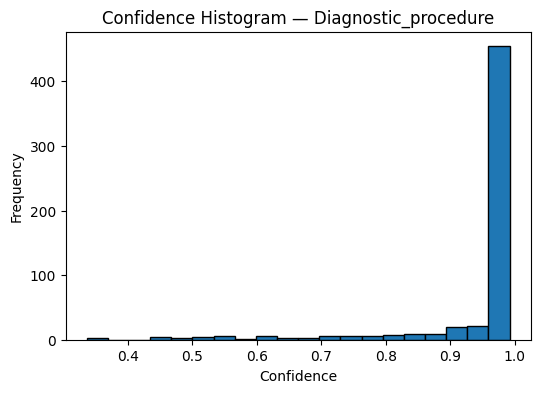

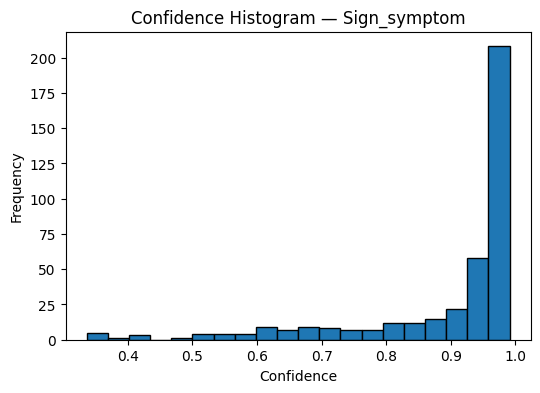

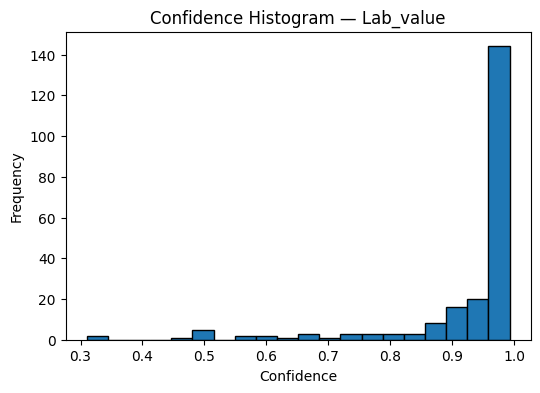

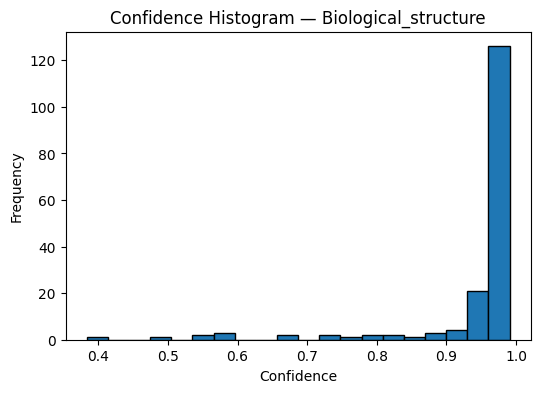

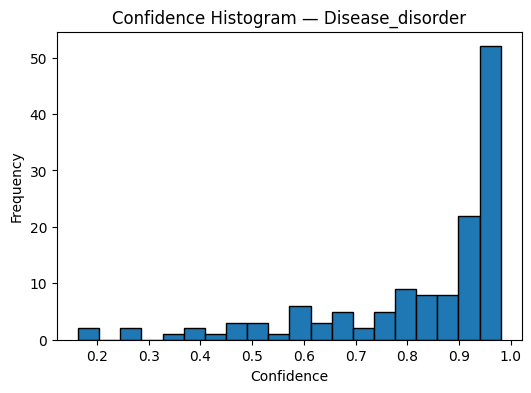

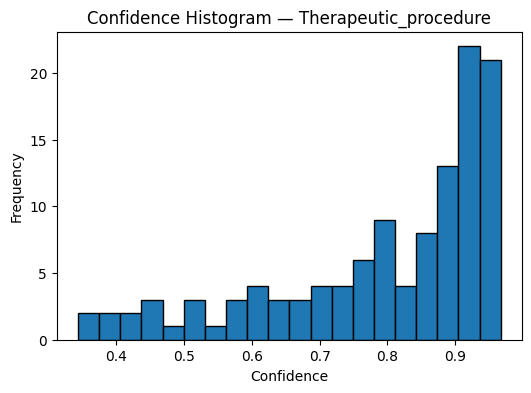

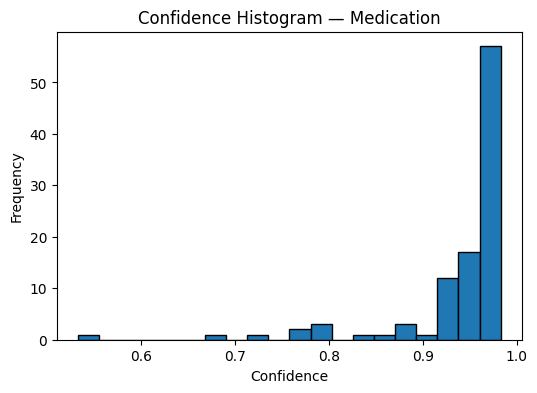

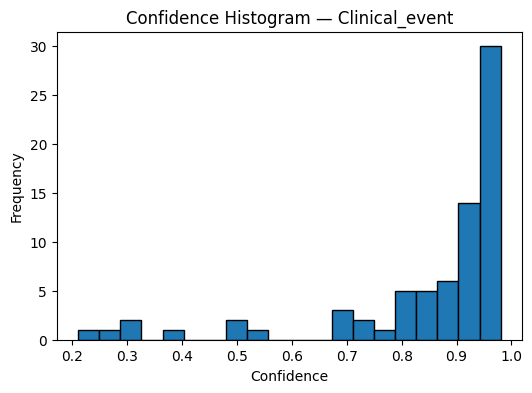

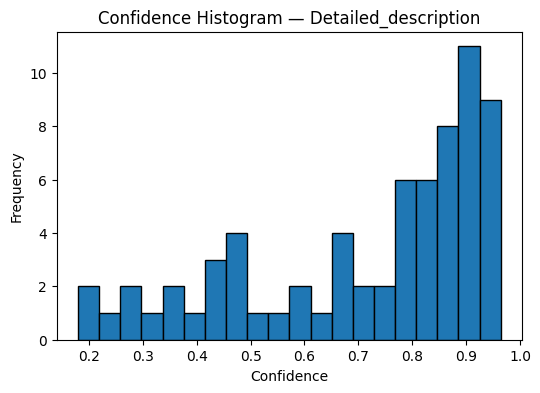

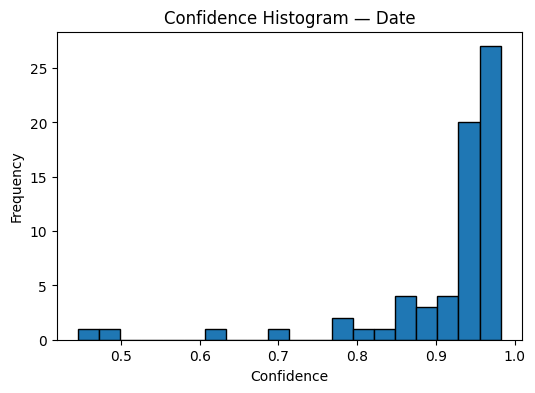

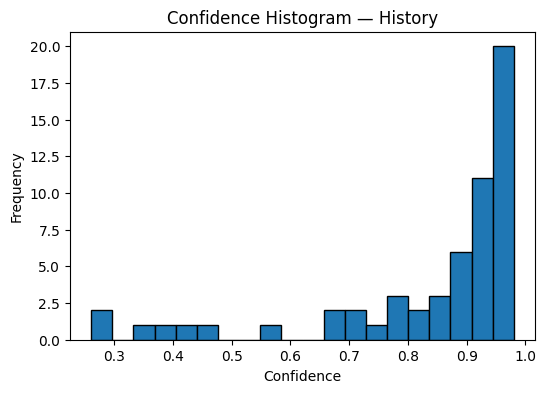

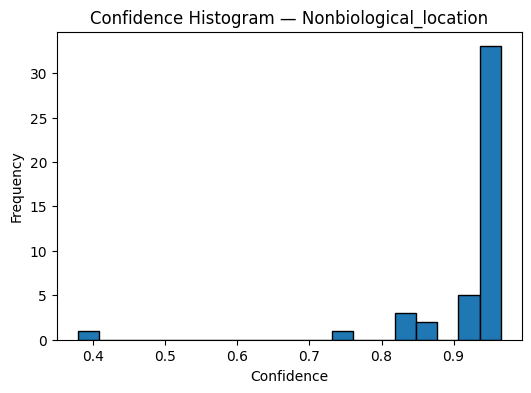

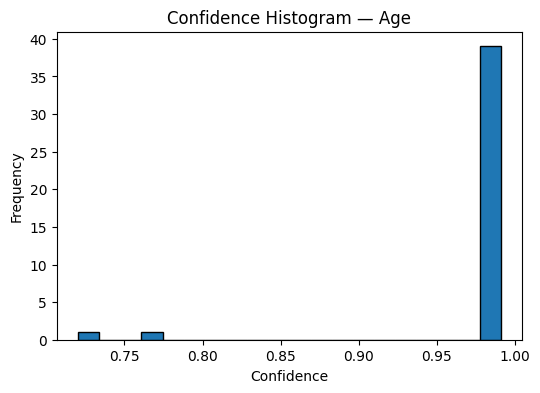

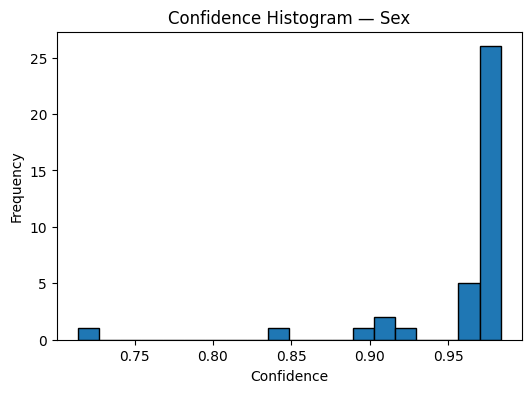

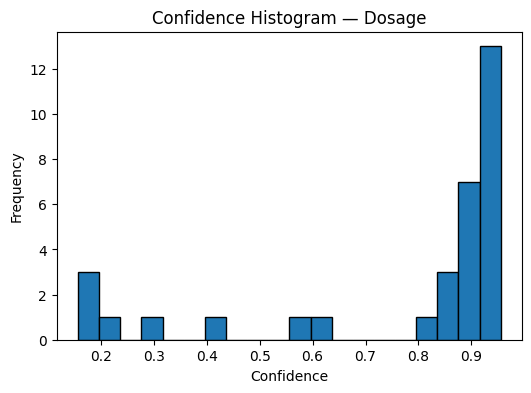

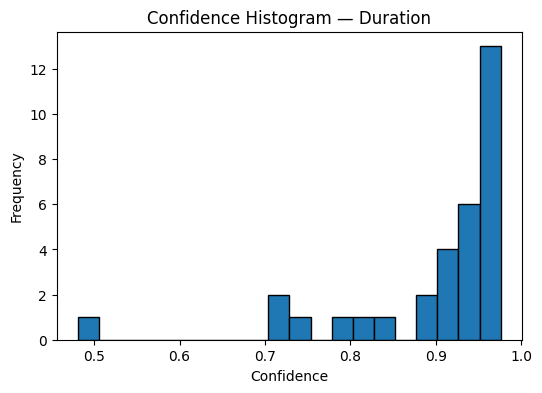

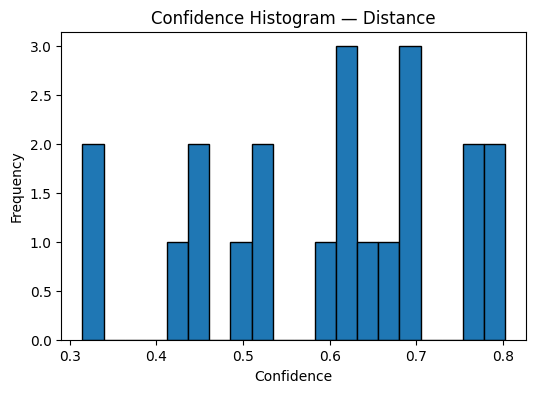

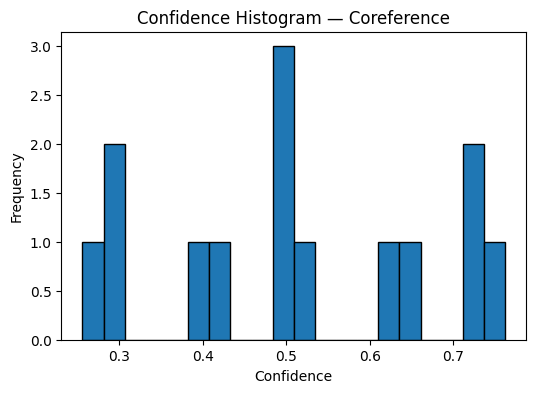

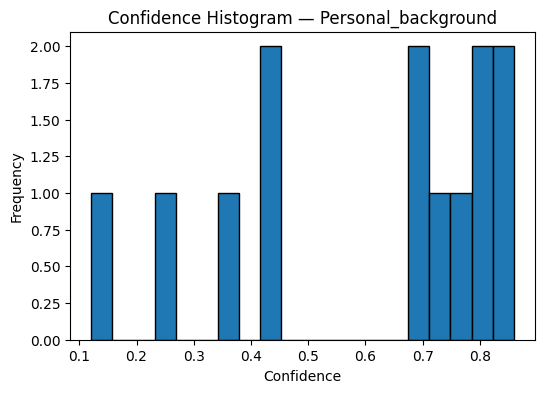

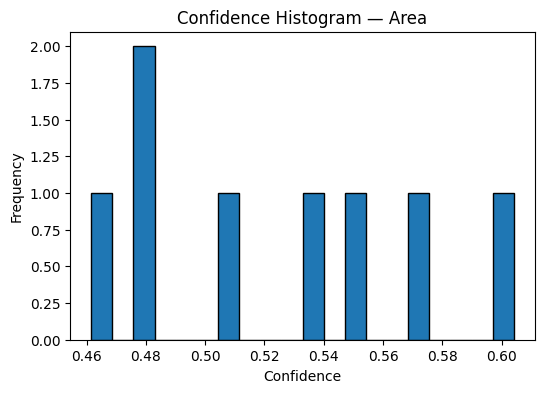

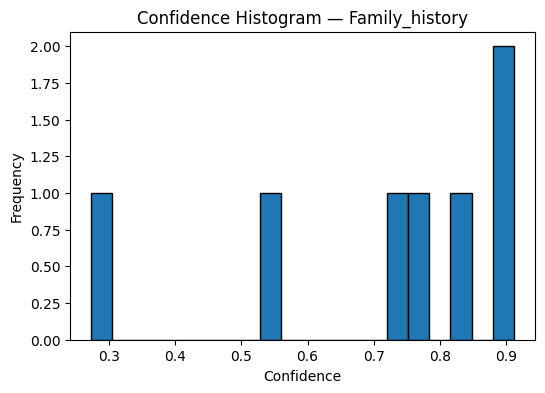

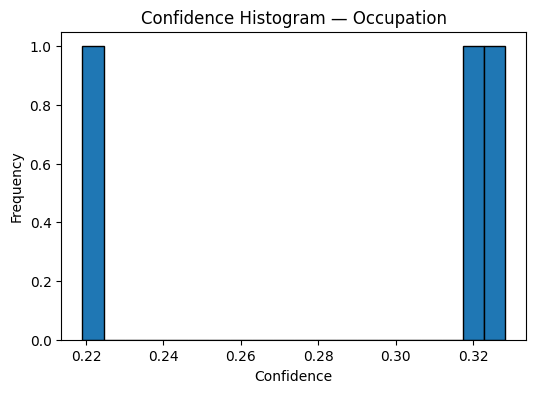

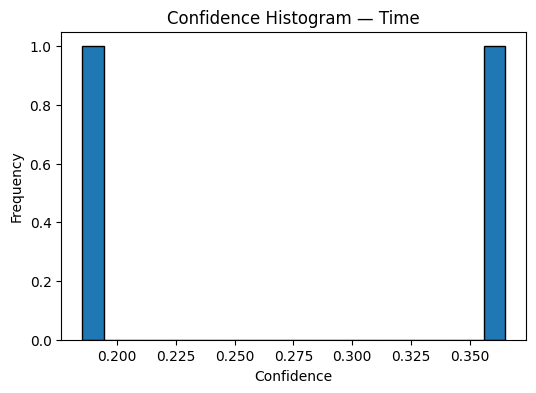

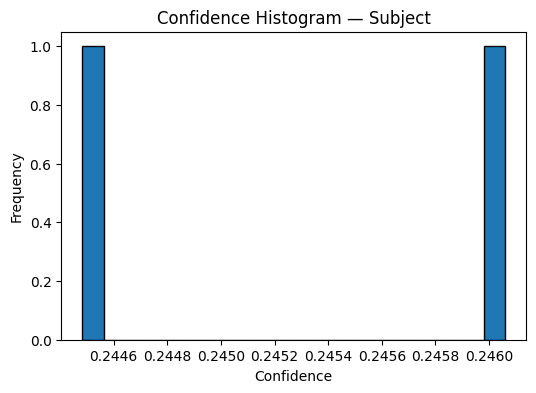

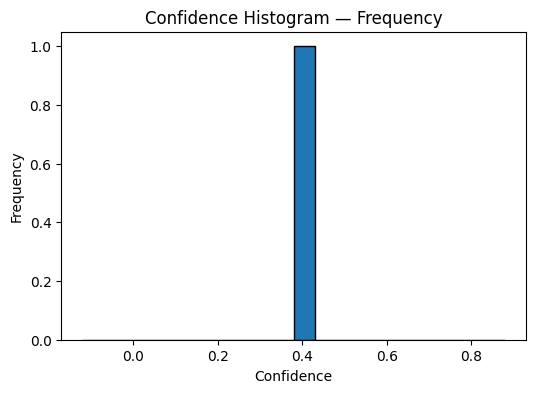

In [44]:
def plot_confidence_hist(entity_conf_stats, entity, bins=20):
    data = entity_conf_stats[entity]
    plt.figure(figsize=(6,4))
    plt.hist(data, bins=bins, edgecolor="black")
    plt.title(f"Confidence Histogram — {entity}")
    plt.xlabel("Confidence")
    plt.ylabel("Frequency")
    wandb.log({f"Confidence_Histogram_{entity}": wandb.Image(plt)})
    plt.show()

for ent in sorted(entity_conf_stats, key=lambda e: -len(entity_conf_stats[e])):
    plot_confidence_hist(entity_conf_stats, ent)

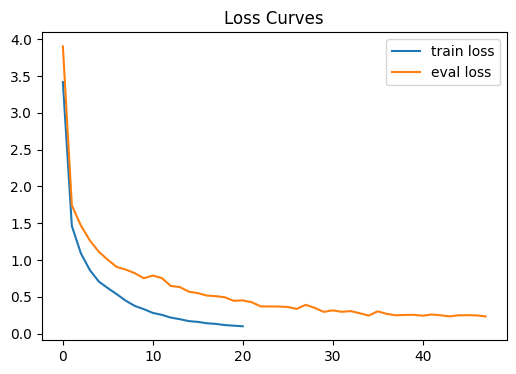

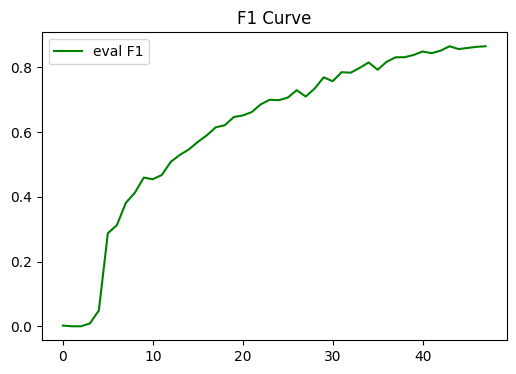

In [45]:
def plot_training_curves(trainer):
    log = trainer.state.log_history

    train_loss = [x["loss"] for x in log if "loss" in x]
    eval_loss  = [x["eval_loss"] for x in log if "eval_loss" in x]
    f1         = [x["eval_f1"] for x in log if "eval_f1" in x]

    # --- Loss ---
    plt.figure(figsize=(6,4))
    plt.plot(train_loss, label="train loss")
    plt.plot(eval_loss, label="eval loss")
    plt.legend()
    plt.title("Loss Curves")
    wandb.log({"Loss_Curves": wandb.Image(plt)})
    plt.show()

    # --- F1 ---
    plt.figure(figsize=(6,4))
    plt.plot(f1, label="eval F1", color="green")
    plt.legend()
    plt.title("F1 Curve")
    wandb.log({"F1_Curve": wandb.Image(plt)})
    plt.show()

plot_training_curves(trainer)

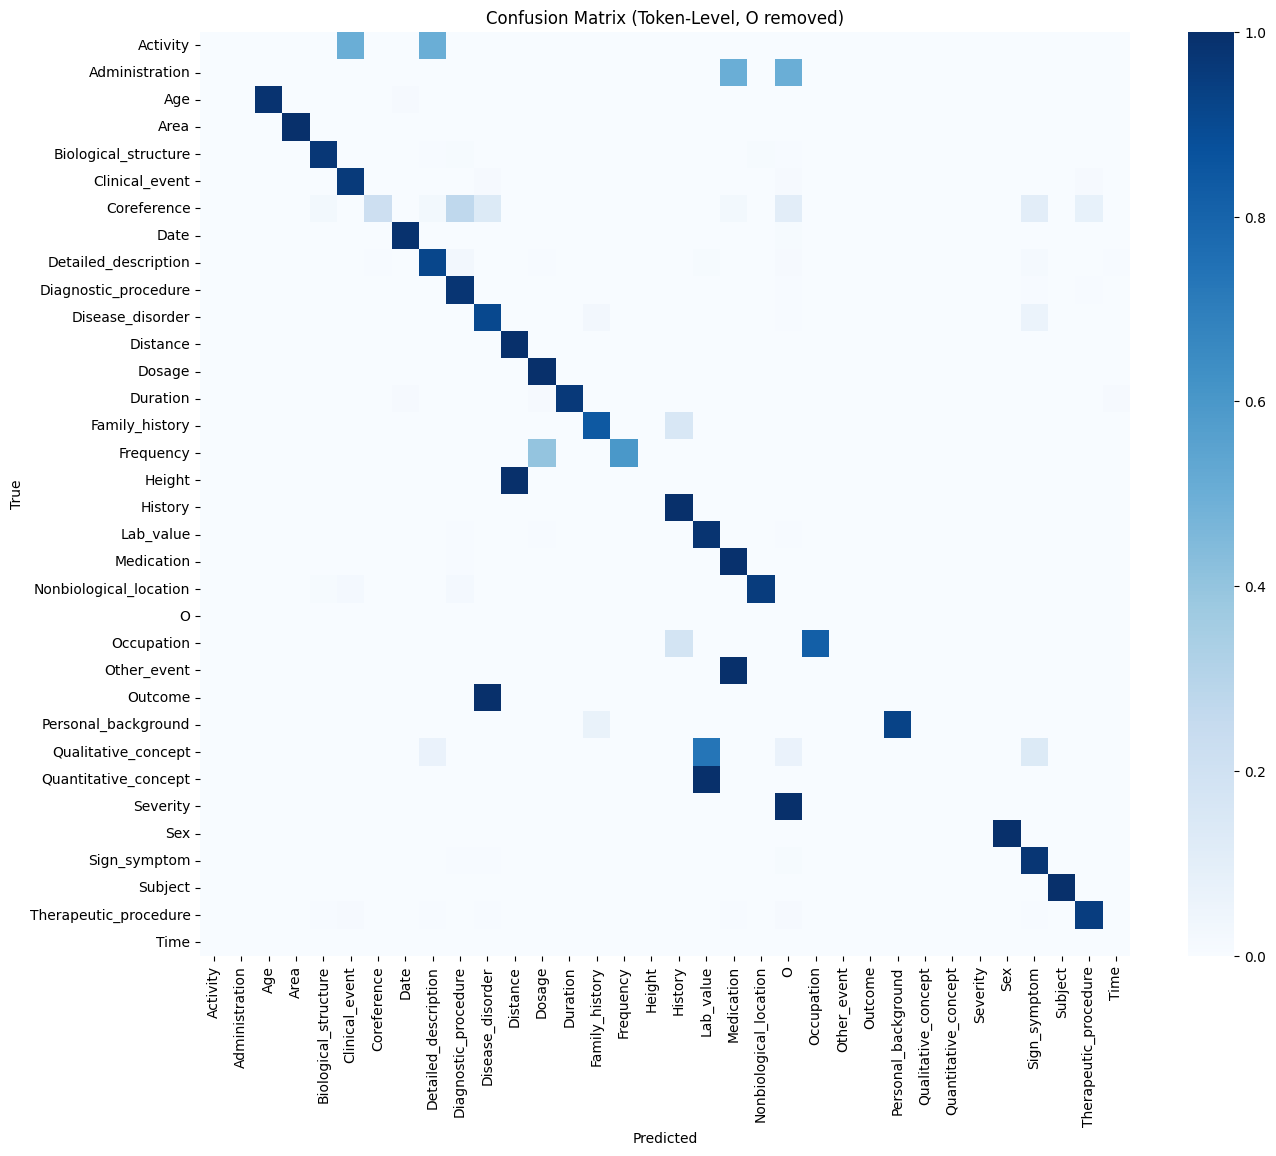

In [46]:
def plot_confusion_matrix(true_tags, pred_tags, labels, wandb_key="Confusion_Matrix"):
    true_flat = [t for seq in true_tags for t in seq]
    pred_flat = [p for seq in pred_tags for p in seq]

    # Filter out "O" labels
    mask = [t != "O" for t in true_flat]
    true_filtered = [t for t, m in zip(true_flat, mask) if m]
    pred_filtered = [p for p, m in zip(pred_flat, mask) if m]

    # Make confusion matrix
    cm = confusion_matrix(true_filtered, pred_filtered, labels=labels, normalize='true')

    # Plot
    plt.figure(figsize=(15, 12))
    sns.heatmap(
        cm,
        xticklabels=labels,
        yticklabels=labels,
        cmap="Blues"
    )
    plt.title("Confusion Matrix (Token-Level, O removed)")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    wandb.log({wandb_key: wandb.Image(plt)})
    plt.show()


# Usage:
def strip_bio(tag):
    return tag.split("-", 1)[1] if tag != "O" else "O"

true_flat = [strip_bio(t) for seq in true_tags for t in seq]
pred_flat = [strip_bio(p) for seq in pred_tags for p in seq]

# Remove O
mask = [t != "O" for t in true_flat]
true_no_o = [t for t, m in zip(true_flat, mask) if m]
pred_no_o = [p for p, m in zip(pred_flat, mask) if m]

# Unique labels without O
entities = sorted(list(set(true_no_o + pred_no_o)))

plot_confusion_matrix([true_no_o], [pred_no_o], entities)

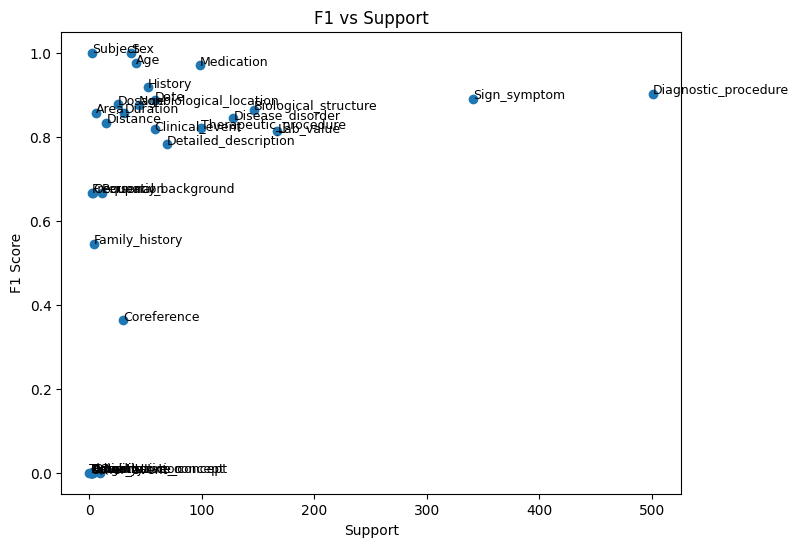

In [47]:
def plot_f1_vs_support(f1_dict, support_dict):
    entities = list(f1_dict.keys())
    f1_vals = [f1_dict[e] for e in entities]
    support_vals = [support_dict[e] for e in entities]

    plt.figure(figsize=(8,6))
    plt.scatter(support_vals, f1_vals)
    for e, s, f in zip(entities, support_vals, f1_vals):
        plt.text(s, f, e, fontsize=9)
    plt.xlabel("Support")
    plt.ylabel("F1 Score")
    plt.title("F1 vs Support")
    wandb.log({"F1_vs_Support": wandb.Image(plt)})
    plt.show()

# Build f1 and support dicts
f1_dict = {}
support_dict = {}
for label, scores_dict in report.items():
    if isinstance(scores_dict, dict):
        f1_dict[label] = scores_dict.get('f1', 0.0)
        support_dict[label] = scores_dict.get('number', 0)

plot_f1_vs_support(f1_dict, support_dict)

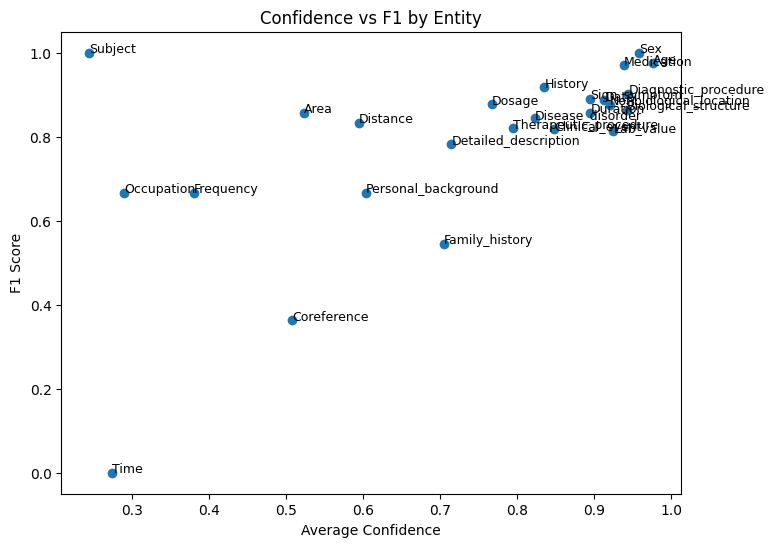

In [48]:
def plot_confidence_vs_f1(entity_conf_stats, f1_dict):
    entities = list(entity_conf_stats.keys())
    avg_conf = [np.mean(entity_conf_stats[e]) for e in entities]
    f1_vals = [f1_dict.get(e, 0) for e in entities]

    plt.figure(figsize=(8,6))
    plt.scatter(avg_conf, f1_vals)
    for e, c, f in zip(entities, avg_conf, f1_vals):
        plt.text(c, f, e, fontsize=9)

    plt.xlabel("Average Confidence")
    plt.ylabel("F1 Score")
    plt.title("Confidence vs F1 by Entity")
    wandb.log({"Confidence_vs_F1": wandb.Image(plt)})
    plt.show()

plot_confidence_vs_f1(entity_conf_stats, f1_dict)

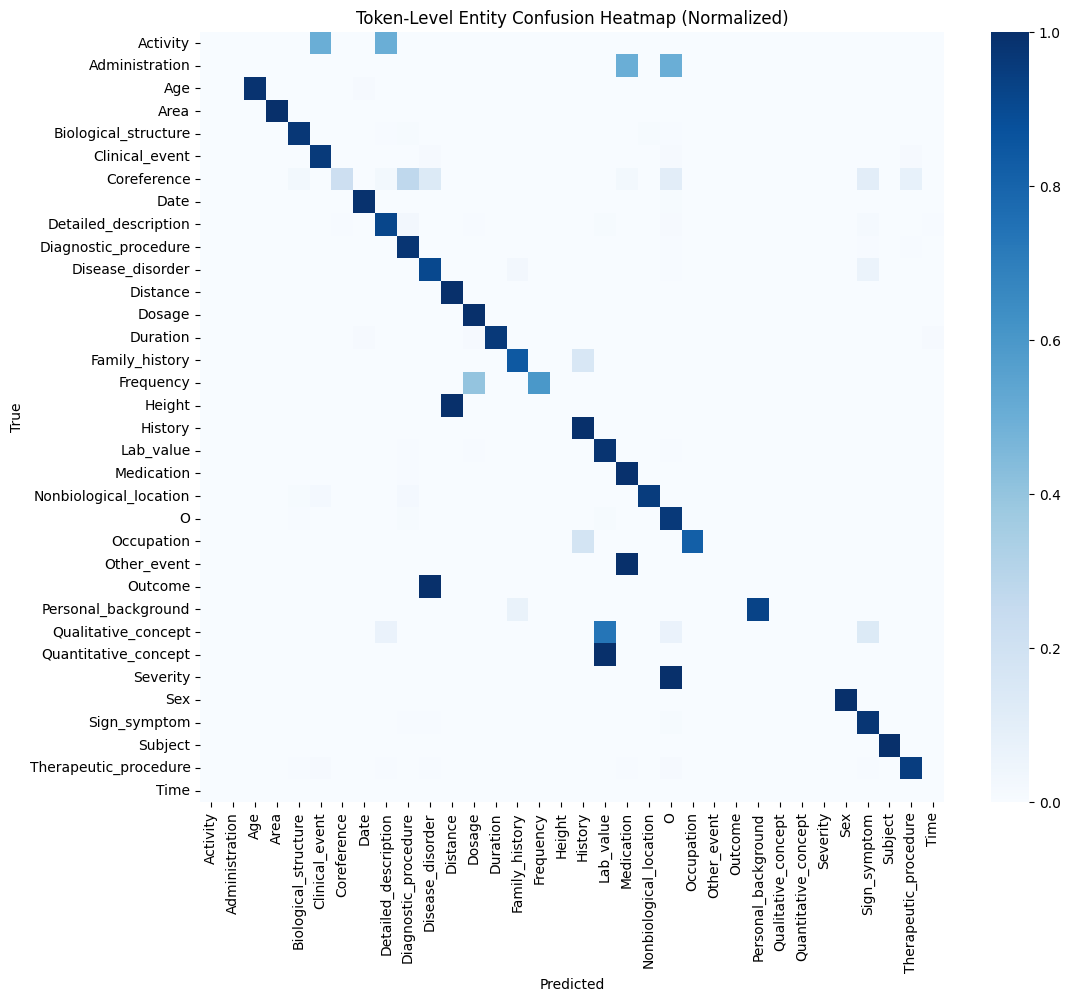

In [49]:
def token_level_error_heatmap(true_tags, pred_tags):
    true_flat = [strip_bio(t) for seq in true_tags for t in seq]
    pred_flat = [strip_bio(p) for seq in pred_tags for p in seq]

    labels = sorted(list(set(true_flat + pred_flat)))
    cm = confusion_matrix(true_flat, pred_flat, labels=labels, normalize="true")

    plt.figure(figsize=(12,10))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.title("Token-Level Entity Confusion Heatmap (Normalized)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    wandb.log({"Token_Level_Error_Heatmap": wandb.Image(plt)})
    plt.show()

# Example:
token_level_error_heatmap(true_tags, pred_tags)

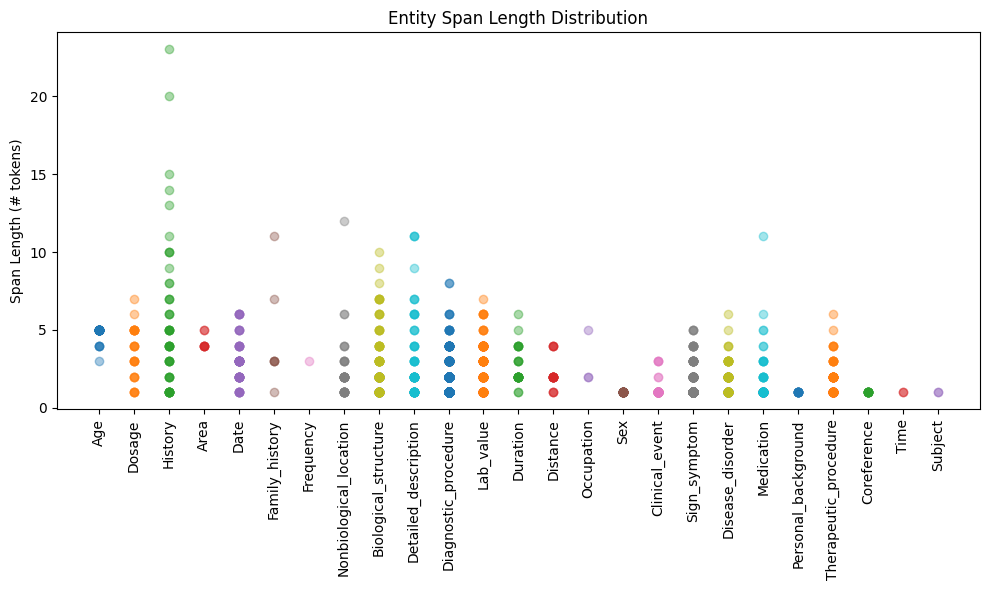

In [50]:
def plot_span_length_distribution(entity_spans):
    lengths = defaultdict(list)

    for span in entity_spans:
        ent_type = span["type"]
        length = len(span["tokens"])
        lengths[ent_type].append(length)

    # Plot entities sorted by median length
    sorted_ents = sorted(lengths.keys(), key=lambda e: np.median(lengths[e]), reverse=True)

    plt.figure(figsize=(10,6))
    for ent in sorted_ents:
        data = lengths[ent]
        plt.scatter([ent]*len(data), data, alpha=0.4)
    
    plt.xticks(rotation=90)
    plt.ylabel("Span Length (# tokens)")
    plt.title("Entity Span Length Distribution")
    plt.tight_layout()
    wandb.log({"Span_Length_Distribution": wandb.Image(plt)})
    plt.show()

# Example:
plot_span_length_distribution(entity_spans)

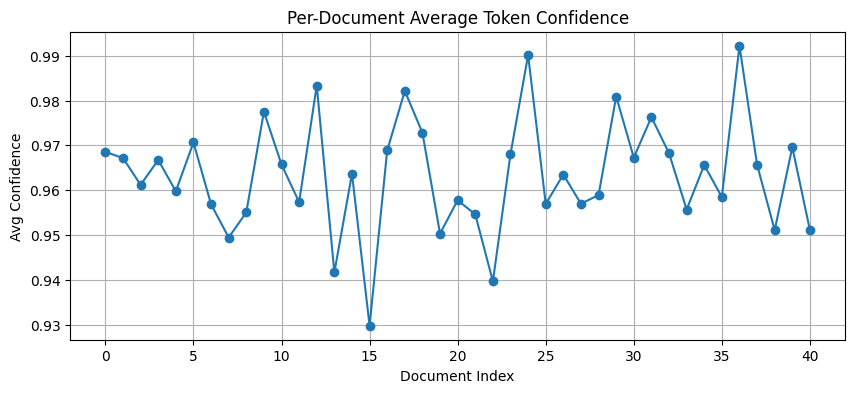

In [51]:
def per_document_confidence_curve(dataset_splits, pred_tags, token_conf):
    doc_conf = []

    for doc_idx, (tokens, tags, confs) in enumerate(zip(
        dataset_splits["validation"]["tokens"],
        pred_tags,
        token_conf
    )):
        if len(confs) == 0:
            avg_conf = 0
        else:
            avg_conf = float(np.mean(confs))
        doc_conf.append(avg_conf)
    
    plt.figure(figsize=(10,4))
    plt.plot(doc_conf, marker='o')
    plt.title("Per-Document Average Token Confidence")
    plt.xlabel("Document Index")
    plt.ylabel("Avg Confidence")
    plt.grid(True)
    wandb.log({"Per_Document_Confidence_Curve": wandb.Image(plt)})
    plt.show()

# Example:
per_document_confidence_curve(dataset_splits, pred_tags, token_conf)

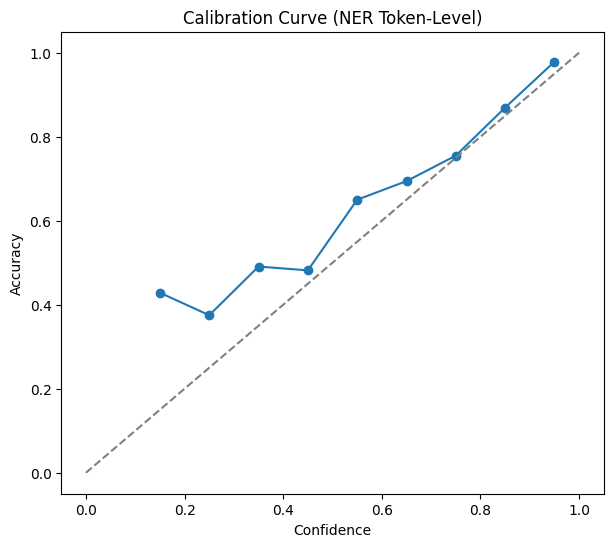

In [52]:
def calibration_curve(true_tags, pred_tags, token_conf, bins=10):
    xs = []
    ys = []

    for tags_true, tags_pred, confs in zip(true_tags, pred_tags, token_conf):
        for t, p, c in zip(tags_true, tags_pred, confs):
            xs.append(c)
            ys.append(1 if t == p else 0)

    xs = np.array(xs)
    ys = np.array(ys)

    bins_edges = np.linspace(0, 1, bins + 1)
    accuracies = []
    centers = []

    for i in range(bins):
        mask = (xs >= bins_edges[i]) & (xs < bins_edges[i+1])
        if mask.sum() == 0:
            continue
        acc = ys[mask].mean()
        accuracies.append(acc)
        centers.append((bins_edges[i] + bins_edges[i+1]) / 2)

    plt.figure(figsize=(7,6))
    plt.plot(centers, accuracies, marker="o")
    plt.plot([0,1], [0,1], "--", color="gray")  # perfection line
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title("Calibration Curve (NER Token-Level)")
    wandb.log({"Calibration_Curve": wandb.Image(plt)})
    plt.show()
calibration_curve(true_tags, pred_tags, token_conf, bins=10)

In [53]:
wandb.finish()

epoch,▁
eval/accuracy,▁▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████
eval/f1,▁▁▁▁▁▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
eval/loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▁▁▂▂▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇███████████
eval/recall,▁▁▁▁▁▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████
eval/runtime,▂▁▂▄▅▆▆▅▆▆▆▅▅▆▆▆▆▅▆▆▅▅▆▆▆▅▆▆▆▆▆▆▆▆█▇▇▆▅▇
eval/samples_per_second,▇█▇▄▄▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▂▂▃▃▁
eval/steps_per_second,▇█▇▄▄▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▂▂▃▃▁
eval_accuracy,▁
eval_f1,▁


In [54]:
del model
del trainer
del tokenizer
del tokenized_data

reset_gpu()

GPU memory reset.
